# Twitter Sentiment analysis with Watson Tone Analyzer and Watson Personality Insight

In this notebook, we perform the following steps:  
1. Install python-twitter and watson-developer-cloud modules
2. Install the streaming twitter jar using PixieDust packageManager
3. Invoke the streaming twitter app using the PixieDust Scala Bridge to get a DataFrame containing all the tweets enriched with Watson Tone Analyzer scores
4. Create a new RDD that groups the tweets by author and concatenates all the associated tweets into one blob
5. For each author and aggregated text, invoke the Watson Personality Insight to get the scores
6. Visualize results using PixieDust display  

## Learn more 
* [Watson Tone Analyzer](http://www.ibm.com/watson/developercloud/tone-analyzer.html)  
* [Watson Personality Insight](http://www.ibm.com/watson/developercloud/personality-insights.html)  
* [python-twitter](https://github.com/bear/python-twitter)  
* [watson-developer-cloud](https://github.com/watson-developer-cloud)  

# Install python-twitter and watson-developer-cloud
If you haven't already installed the following modules, run these 2 cells:

In [ ]:
!pip install --user python-twitter

In [ ]:
!pip install --user watson-developer-cloud

## Install the streaming twitter jar in the notebook from the Github repo
This jar file contains the Spark Streaming application (written in Scala) that connects to Twitter to fetch the tweets and send them to Watson Tone Analyzer for analysis. The resulting scores are then added to the tweets dataframe as separate columns.

In [1]:
import pixiedust
jarPath = "https://github.com/ibm-cds-labs/spark.samples/raw/master/dist/streaming-twitter-assembly-1.6.jar"
pixiedust.installPackage(jarPath)
print("done")

Pixiedust database opened successfully
Pixiedust version 0.57
Package already installed: https://github.com/ibm-cds-labs/spark.samples/raw/master/dist/streaming-twitter-assembly-1.6.jar
done


## Use Scala Bridge to run the command line version of the app
Insert your credentials for Twitter, Watson Tone Analyzer, and Watson Personality Insights. Then run the following cell. 
[Read how to provision these services and get credentials](https://github.com/ibm-cds-labs/spark.samples/blob/master/notebook/Get%20Service%20Credentials%20for%20Twitter%20Sentiment%20with%20Watson%20TA%20and%20PI.md). 

In [18]:
sqlContext=SQLContext(sc)

#Set up the twitter credentials, they will be used both in scala and python cells below
consumerKey = "XXXX"
consumerSecret = "XXXX"
accessToken = "XXXX"
accessTokenSecret = "XXXX"

#Set up the Watson Personality insight credentials
piUserName = "XXXX"
piPassword = "XXXX"

#Set up the Watson Tone Analyzer credentials
taUserName = "XXXX"
taPassword = "XXXX"

In [19]:
%%scala
val demo = com.ibm.cds.spark.samples.StreamingTwitter
demo.setConfig("twitter4j.oauth.consumerKey",consumerKey)
demo.setConfig("twitter4j.oauth.consumerSecret",consumerSecret)
demo.setConfig("twitter4j.oauth.accessToken",accessToken)
demo.setConfig("twitter4j.oauth.accessTokenSecret",accessTokenSecret)
demo.setConfig("watson.tone.url","https://gateway.watsonplatform.net/tone-analyzer/api")
demo.setConfig("watson.tone.password",taPassword)
demo.setConfig("watson.tone.username",taUserName)

import org.apache.spark.streaming._
demo.startTwitterStreaming(sc, Seconds(30))  //Run the application for a limited time

Starting twitter stream
Twitter stream started
Tweets are collected real-time and analyzed
To stop the streaming and start interacting with the data use: StreamingTwitter.stopTwitterStreaming
Receiver Started: TwitterReceiver-0
Batch started with 62 records
Batch completed with 62 records
Batch started with 210 records
Batch completed with 210 records
Batch started with 237 records
Stopping Twitter stream. Please wait this may take a while
Receiver Stopped: TwitterReceiver-0
Reason:  : Stopped by driver
Twitter stream stopped
You can now create a sqlContext and DataFrame with 84 Tweets created. Sample usage: 
val (sqlContext, df) = com.ibm.cds.spark.samples.StreamingTwitter.createTwitterDataFrames(sc)
df.printSchema
sqlContext.sql("select author, text from tweets").show


# Create a tweets dataframe from the data fetched above and transfer it to Python
Notice the __ prefix for each variable which is used to signal PixieDust that the variable needs to be transfered back to Python

In [6]:
%%scala
val demo = com.ibm.cds.spark.samples.StreamingTwitter
val (__sqlContext, __df) = demo.createTwitterDataFrames(sc)

A new table named tweets with 115 records has been correctly created and can be accessed through the SQLContext variable
Here's the schema for tweets
root
 |-- author: string (nullable = true)
 |-- userid: string (nullable = true)
 |-- date: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- text: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- Anger: double (nullable = true)
 |-- Disgust: double (nullable = true)
 |-- Fear: double (nullable = true)
 |-- Joy: double (nullable = true)
 |-- Sadness: double (nullable = true)
 |-- Analytical: double (nullable = true)
 |-- Confident: double (nullable = true)
 |-- Tentative: double (nullable = true)
 |-- Openness: double (nullable = true)
 |-- Conscientiousness: double (nullable = true)
 |-- Extraversion: double (nullable = true)
 |-- Agreeableness: double (nullable = true)
 |-- EmotionalRange: double (nullable = true)



## Group the tweets by author and userid
This will be used later to fetch the last 100 tweets for each author

In [7]:
import pyspark.sql.functions as F
usersDF = __df.groupby("author", "userid").agg(F.avg("Anger").alias("Anger"), F.avg("Disgust").alias("Disgust"))
usersDF.show()

+--------------------+---------------+-----------------+------------------+
|              author|         userid|            Anger|           Disgust|
+--------------------+---------------+-----------------+------------------+
|         S A B E L ❣|    theyloveeva|              3.0|               2.0|
|       Brett horvath|   bretthorvath|             27.0|               5.0|
|                nanï|    nabilanani1|              3.0|14.000000000000002|
|           Xenocrypt|  xenocryptsite|              9.0|               1.0|
|    The Coffee Shack|  PantherBailey|             16.0|               6.0|
|                ㅤbek|     twinoskian|7.000000000000001|               1.0|
|          John White|   juanblanco76|              8.0|               1.0|
|   AJIT SINGH PUNDIR|ajitsinghpundir|              2.0|14.000000000000002|
|              XV-III| princesse_ASNK|             10.0|              25.0|
|          Matt Mazey|        m_mazey|              5.0|               4.0|
|           

# Set up the twitter api from python-twitter module

In [8]:
import twitter
api = twitter.Api(consumer_key=consumerKey,
                  consumer_secret=consumerSecret,
                  access_token_key=accessToken,
                  access_token_secret=accessTokenSecret)

#print(api.VerifyCredentials())

# For each author, fetch the last 200 tweets
use flatMap to return a new RDD that contains a list of tuples composed of userid and tweets text: (userid, tweetText)

In [9]:
def getTweets(screenName):
    statuses = api.GetUserTimeline(screen_name=screenName,
                        since_id=None,
                        max_id=None,
                        count=200,
                        include_rts=False,
                        trim_user=False,
                        exclude_replies=True)
    return statuses

usersWithTweetsRDD = usersDF.flatMap(lambda s: [(s.user.screen_name, s.text.encode('ascii', 'ignore')) for s in getTweets(s['userid'])])
print(usersWithTweetsRDD.count())

9029


# Concatenate all the tweets for each user so we have enough words to send to Watson Personality Insight
* Use map to create an RDD of key, value pair composed of userId and tweets 
* Use reduceByKey to group all record with same author and concatenate the tweets

In [10]:
import re
usersWithTweetsRDD2 = usersWithTweetsRDD.map(lambda s: (s[0], s[1])).reduceByKey(lambda s,t: s + '\n' + t)\
    .filter(lambda s: len(re.findall(r'\w+', s[1])) > 100 )
print(usersWithTweetsRDD2.count())
#usersWithTweetsRDD2.take(2)

97


# Call Watson Personality Insights on the text for each author
Watson Personality Insights requires at least 100 words from its lexicon to be available, which may not exist for each user. This is why the getPersonlityInsight helper function guards against exceptions from calling Watson PI. If an exception occurs, then an empty array is returned. Each record with empty array is filtered out of the resulting RDD.

Note also that we use broadcast variables to propagate the userName and password to the cluster

In [11]:
from pyspark.sql.types import *
from watson_developer_cloud import PersonalityInsightsV3
broadCastPIUsername = sc.broadcast(piUserName)
broadCastPIPassword = sc.broadcast(piPassword)
def getPersonalityInsight(text, schema=False):
    personality_insights = PersonalityInsightsV3(
          version='2016-10-20',
          username=broadCastPIUsername.value,
          password=broadCastPIPassword.value)
    try:
        p = personality_insights.profile(
            text, content_type='text/plain',
            raw_scores=True, consumption_preferences=True)
        if schema:
            return \
                [StructField(t['name'], FloatType()) for t in p["needs"]] + \
                [StructField(t['name'], FloatType()) for t in p["values"]] + \
                [StructField(t['name'], FloatType()) for t in p['personality'] for v in t['children'] ]
        else:
            return \
                [t['raw_score'] for t in p["needs"]] + \
                [t['raw_score'] for t in p["values"]] + \
                [v['raw_score'] for t in p['personality'] for v in t['children'] ]   
    except:
        return []

usersWithPIRDD = usersWithTweetsRDD2.map(lambda s: [s[0]] + getPersonalityInsight(s[1])).filter(lambda s: len(s)>1)
print(usersWithPIRDD.count())
#usersWithPIRDD.take(2)

96


# Convert the RDD back to a DataFrame and call PixieDust display to visualize the results
The schema is automatically created from introspecting a sample payload result from Watson Personality Insights

In [12]:
#convert to dataframe
schema = StructType(
    [StructField('userid',StringType())] + getPersonalityInsight(usersWithTweetsRDD2.take(1)[0][1], schema=True)
)

usersWithPIDF = sqlContext.createDataFrame(
    usersWithPIRDD, schema
)

usersWithPIDF.cache()
display(usersWithPIDF)

# Optional: do some extra data science on the tweets

In [13]:
tweets=__df
tweets.count()
display(tweets)

# Compute the sentiment distributions for tweets with scores greater than 60% and create matplotlib chart visualization

In [14]:
#create an array that will hold the count for each sentiment
sentimentDistribution=[0] * 13
#For each sentiment, run a sql query that counts the number of tweets for which the sentiment score is greater than 60%
#Store the data in the array
for i, sentiment in enumerate(tweets.columns[-13:]):
    sentimentDistribution[i]=__sqlContext.sql("SELECT count(*) as sentCount FROM tweets where " + sentiment + " > 60")\
        .collect()[0].sentCount

/Users/dtaieb/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/Users/dtaieb/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/Users/dtaieb/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/Users/dtaieb/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata

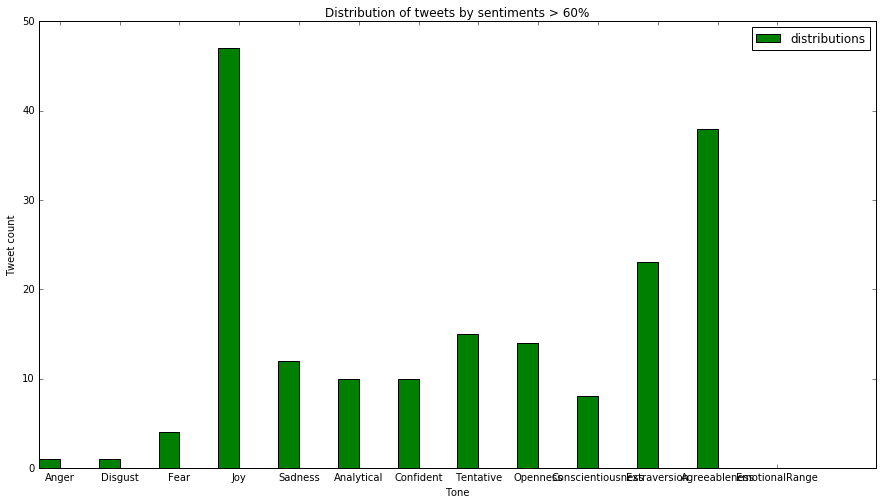

In [15]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

ind=np.arange(13)
width = 0.35
bar = plt.bar(ind, sentimentDistribution, width, color='g', label = "distributions")

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2.5, plSize[1]*2) )
plt.ylabel('Tweet count')
plt.xlabel('Tone')
plt.title('Distribution of tweets by sentiments > 60%')
plt.xticks(ind+width, tweets.columns[-13:])
plt.legend()

plt.show()

# Compute the top hashtags used in each tweet

In [16]:
from operator import add
import re
tagsRDD = tweets.flatMap( lambda t: re.split("\s", t.text))\
    .filter( lambda word: word.startswith("#") )\
    .map( lambda word : (word, 1 ))\
    .reduceByKey(add, 10).map(lambda (a,b): (b,a)).sortByKey(False).map(lambda (a,b):(b,a))
top10tags = tagsRDD.take(10)

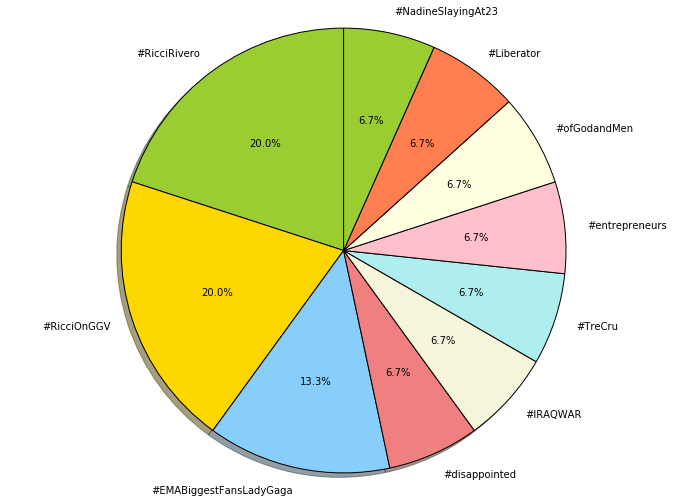

In [17]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*2) )

labels = [i[0] for i in top10tags]
sizes = [int(i[1]) for i in top10tags]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', "beige", "paleturquoise", "pink", "lightyellow", "coral"]

plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.show()

# Compute the aggregate sentiment distribution for all the tweets that contain the top hashtags

In [ ]:
cols = tweets.columns[-13:]
def expand( t ):
    ret = []
    for s in [i[0] for i in top10tags]:
        if ( s in t.text ):
            for tone in cols:
                ret += [s.replace(':','').replace('-','') + u"-" + unicode(tone) + ":" + unicode(getattr(t, tone))]
    return ret 
def makeList(l):
    return l if isinstance(l, list) else [l]

#Create RDD from tweets dataframe
tagsRDD = tweets.map(lambda t: t )

#Filter to only keep the entries that are in top10tags
tagsRDD = tagsRDD.filter( lambda t: any(s in t.text for s in [i[0] for i in top10tags] ) )

#Create a flatMap using the expand function defined above, this will be used to collect all the scores 
#for a particular tag with the following format: Tag-Tone-ToneScore
tagsRDD = tagsRDD.flatMap( expand )

#Create a map indexed by Tag-Tone keys 
tagsRDD = tagsRDD.map( lambda fullTag : (fullTag.split(":")[0], float( fullTag.split(":")[1]) ))

#Call combineByKey to format the data as follow
#Key=Tag-Tone
#Value=(count, sum_of_all_score_for_this_tone)
tagsRDD = tagsRDD.combineByKey((lambda x: (x,1)),
                  (lambda x, y: (x[0] + y, x[1] + 1)),
                  (lambda x, y: (x[0] + y[0], x[1] + y[1])))

#ReIndex the map to have the key be the Tag and value be (Tone, Average_score) tuple
#Key=Tag
#Value=(Tone, average_score)
tagsRDD = tagsRDD.map(lambda (key, ab): (key.split("-")[0], (key.split("-")[1], round(ab[0]/ab[1], 2))))

#Reduce the map on the Tag key, value becomes a list of (Tone,average_score) tuples
tagsRDD = tagsRDD.reduceByKey( lambda x, y : makeList(x) + makeList(y) )

#Sort the (Tone,average_score) tuples alphabetically by Tone
tagsRDD = tagsRDD.mapValues( lambda x : sorted(x) )

#Format the data as expected by the plotting code in the next cell. 
#map the Values to a tuple as follow: ([list of tone], [list of average score])
#e.g. #someTag:([u'Agreeableness', u'Analytical', u'Anger', u'Cheerfulness', u'Confident', u'Conscientiousness', u'Negative', u'Openness', u'Tentative'], [1.0, 0.0, 0.0, 1.0, 0.0, 0.48, 0.0, 0.02, 0.0])
tagsRDD = tagsRDD.mapValues( lambda x : ([elt[0] for elt in x],[elt[1] for elt in x])  )

#Use custom sort function to sort the entries by order of appearance in top10tags
def customCompare( key ):
    for (k,v) in top10tags:
        if k == key:
            return v
    return 0
tagsRDD = tagsRDD.sortByKey(ascending=False, numPartitions=None, keyfunc = customCompare)

#Take the mean tone scores for the top 10 tags
top10tagsMeanScores = tagsRDD.take(10)

In [ ]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*3, plSize[1]*2) )

top5tagsMeanScores = top10tagsMeanScores[:5]
width = 0
ind=np.arange(13)
(a,b) = top5tagsMeanScores[0]
labels=b[0]
colors = ["beige", "paleturquoise", "pink", "lightyellow", "coral", "lightgreen", "gainsboro", "aquamarine","c"]
idx=0
for key, value in top5tagsMeanScores:
    plt.bar(ind + width, value[1], 0.15, color=colors[idx], label=key)
    width += 0.15
    idx += 1
plt.xticks(ind+0.3, labels)
plt.ylabel('AVERAGE SCORE')
plt.xlabel('TONES')
plt.title('Breakdown of top hashtags by sentiment tones')

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='center',ncol=5, mode="expand", borderaxespad=0.)

plt.show()

# Optional: Use Twitter demo embedded app to run the same app with a UI

In [ ]:
%%scala
val demo = com.ibm.cds.spark.samples.PixiedustStreamingTwitter
demo.setConfig("twitter4j.oauth.consumerKey",consumerKey)
demo.setConfig("twitter4j.oauth.consumerSecret",consumerSecret)
demo.setConfig("twitter4j.oauth.accessToken",accessToken)
demo.setConfig("twitter4j.oauth.accessTokenSecret",accessTokenSecret)
demo.setConfig("watson.tone.url","https://gateway.watsonplatform.net/tone-analyzer/api")
demo.setConfig("watson.tone.password",taPassword)
demo.setConfig("watson.tone.username",taUserName)
demo.setConfig("checkpointDir", System.getProperty("user.home") + "/pixiedust/ssc")

In [ ]:
from pixiedust_twitterdemo import *
twitterDemo()

## The embedded app has generated a DataFrame called __tweets. Let's use it to do some data science

In [ ]:
display(__tweets)

In [ ]:
from pyspark.sql import Row
from pyspark.sql.types import *
emotions=__tweets.columns[-13:]
distrib = __tweets.flatMap(lambda t: [(x,t[x]) for x in emotions]).filter(lambda t: t[1]>60)\
    .toDF(StructType([StructField('emotion',StringType()),StructField('score',DoubleType())]))
display(distrib)

In [ ]:
__tweets.registerTempTable("pixiedust_tweets")
#create an array that will hold the count for each sentiment
sentimentDistribution=[0] * 13
#For each sentiment, run a sql query that counts the number of tweets for which the sentiment score is greater than 60%
#Store the data in the array
for i, sentiment in enumerate(__tweets.columns[-13:]):
    sentimentDistribution[i]=sqlContext.sql("SELECT count(*) as sentCount FROM pixiedust_tweets where " + sentiment + " > 60")\
        .collect()[0].sentCount

In [ ]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

ind=np.arange(13)
width = 0.35
bar = plt.bar(ind, sentimentDistribution, width, color='g', label = "distributions")

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2.5, plSize[1]*2) )
plt.ylabel('Tweet count')
plt.xlabel('Tone')
plt.title('Distribution of tweets by sentiments > 60%')
plt.xticks(ind+width, __tweets.columns[-13:])
plt.legend()

plt.show()

In [ ]:
from operator import add
import re
tagsRDD = __tweets.flatMap( lambda t: re.split("\s", t.text))\
    .filter( lambda word: word.startswith("#") )\
    .map( lambda word : (word, 1 ))\
    .reduceByKey(add, 10).map(lambda (a,b): (b,a)).sortByKey(False).map(lambda (a,b):(b,a))
top10tags = tagsRDD.take(10)

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*2) )

labels = [i[0] for i in top10tags]
sizes = [int(i[1]) for i in top10tags]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', "beige", "paleturquoise", "pink", "lightyellow", "coral"]

plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.show()

In [ ]:
cols = __tweets.columns[-13:]
def expand( t ):
    ret = []
    for s in [i[0] for i in top10tags]:
        if ( s in t.text ):
            for tone in cols:
                ret += [s.replace(':','').replace('-','') + u"-" + unicode(tone) + ":" + unicode(getattr(t, tone))]
    return ret 
def makeList(l):
    return l if isinstance(l, list) else [l]

#Create RDD from tweets dataframe
tagsRDD = __tweets.map(lambda t: t )

#Filter to only keep the entries that are in top10tags
tagsRDD = tagsRDD.filter( lambda t: any(s in t.text for s in [i[0] for i in top10tags] ) )

#Create a flatMap using the expand function defined above, this will be used to collect all the scores 
#for a particular tag with the following format: Tag-Tone-ToneScore
tagsRDD = tagsRDD.flatMap( expand )

#Create a map indexed by Tag-Tone keys 
tagsRDD = tagsRDD.map( lambda fullTag : (fullTag.split(":")[0], float( fullTag.split(":")[1]) ))

#Call combineByKey to format the data as follow
#Key=Tag-Tone
#Value=(count, sum_of_all_score_for_this_tone)
tagsRDD = tagsRDD.combineByKey((lambda x: (x,1)),
                  (lambda x, y: (x[0] + y, x[1] + 1)),
                  (lambda x, y: (x[0] + y[0], x[1] + y[1])))

#ReIndex the map to have the key be the Tag and value be (Tone, Average_score) tuple
#Key=Tag
#Value=(Tone, average_score)
tagsRDD = tagsRDD.map(lambda (key, ab): (key.split("-")[0], (key.split("-")[1], round(ab[0]/ab[1], 2))))

#Reduce the map on the Tag key, value becomes a list of (Tone,average_score) tuples
tagsRDD = tagsRDD.reduceByKey( lambda x, y : makeList(x) + makeList(y) )

#Sort the (Tone,average_score) tuples alphabetically by Tone
tagsRDD = tagsRDD.mapValues( lambda x : sorted(x) )

#Format the data as expected by the plotting code in the next cell. 
#map the Values to a tuple as follow: ([list of tone], [list of average score])
#e.g. #someTag:([u'Agreeableness', u'Analytical', u'Anger', u'Cheerfulness', u'Confident', u'Conscientiousness', u'Negative', u'Openness', u'Tentative'], [1.0, 0.0, 0.0, 1.0, 0.0, 0.48, 0.0, 0.02, 0.0])
tagsRDD = tagsRDD.mapValues( lambda x : ([elt[0] for elt in x],[elt[1] for elt in x])  )

#Use custom sort function to sort the entries by order of appearance in top10tags
def customCompare( key ):
    for (k,v) in top10tags:
        if k == key:
            return v
    return 0
tagsRDD = tagsRDD.sortByKey(ascending=False, numPartitions=None, keyfunc = customCompare)

#Take the mean tone scores for the top 10 tags
top10tagsMeanScores = tagsRDD.take(10)

In [ ]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*3, plSize[1]*2) )

top5tagsMeanScores = top10tagsMeanScores[:5]
width = 0
ind=np.arange(13)
(a,b) = top5tagsMeanScores[0]
labels=b[0]
colors = ["beige", "paleturquoise", "pink", "lightyellow", "coral", "lightgreen", "gainsboro", "aquamarine","c"]
idx=0
for key, value in top5tagsMeanScores:
    plt.bar(ind + width, value[1], 0.15, color=colors[idx], label=key)
    width += 0.15
    idx += 1
plt.xticks(ind+0.3, labels)
plt.ylabel('AVERAGE SCORE')
plt.xlabel('TONES')
plt.title('Breakdown of top hashtags by sentiment tones')

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='center',ncol=5, mode="expand", borderaxespad=0.)

plt.show()